**Base de Dados**

https://finance.yahoo.com/quote/PETR4.SA/history?

Escolho o período: 01/jan/2004 até 22/ago/2024

Esse código busca prever o preço das ações da PETROBRAS com base em dados históricos, usando uma rede neural LSTM treinada em séries temporais. Ele divide os dados em conjuntos de treinamento, validação e teste, normaliza os valores, constrói e treina o modelo, e finalmente faz previsões que são comparadas aos valores reais.

## **1 - Importação dos módulos e bibliotecas**

In [ ]:
# Primeiro, vamos importar os módulos models e layers.
# O primeiro possui classes e funções usadas para construir, compilar, treinar e avaliar modelos de redes neurais.
# O segundo
from keras import models, layers
#"Dense" é uma camada totalmente conectada, "Dropout" é usada para prevenir overfitting, e
#from keras import layers  # módulo com várias classes que são camadas usadas para construir redes neurais
import numpy as np  # biblioteca destinada a realizar operações em arrays multidimensionais
import pandas as pd # biblioteca para manipulação e análise de dados, especialmente útil para estruturas de dados tabulares
from sklearn import preprocessing #MinMaxScaler # função para normalizar os dados no intervalo (0,1)

# Com base nos dados históricos, quero prever o preço das ações

# Carrega os dados históricos das ações de 01/jan/2004 até 22/jun/2024
#data = pd.read_csv('PETR4.SA2-Git.csv')
data = pd.read_csv('PETR4.SA-1.csv')

print(data.head(8)) # vamos exibir apenas 8  linhas

data = data.dropna()   #elimina os registros com valores nulos para garantir que o modelo não receba entradas incompletas

# Seleciona a coluna de preços de fechamento das ações (5ª coluna) e a converte em um array NumPy
# lembre-se que eu preciso indicar os indices 4:5 para selecionar a coluna 5
preco = data.iloc[:,4:5].values

preco.shape


         Date      Open      High       Low     Close  Adj Close      Volume
0  2004-01-01   9.55000   9.55000   9.55000   9.55000   2.279711         0.0
1  2004-01-02   9.55000   9.90000   9.55000   9.90000   2.363260  23606400.0
2  2004-01-05   9.98625  10.49875   9.98125  10.47500   2.500520  44755200.0
3  2004-01-06  10.62625  11.02500  10.46250  11.02500   2.631812  77187200.0
4  2004-01-07  11.00000  11.56250  10.90000  10.90875   2.604062  71033600.0
5  2004-01-08  11.12500  11.12500  10.62500  10.84375   2.588545  55296000.0
6  2004-01-09  10.90250  10.95625  10.68750  10.72500   2.560198  42944000.0
7  2004-01-12  10.75375  11.01250  10.70000  10.73750   2.563183  48848000.0


(5145, 1)

## **2 - Separação dos Dados**

Vamos separar os dados entre treinamento, validação e teste

80% dos dados para treinamento

10% para validação

10% para teste

**Dados de treinamento, validação e teste**: dados que serão utilizados para treinar e testar o modelo

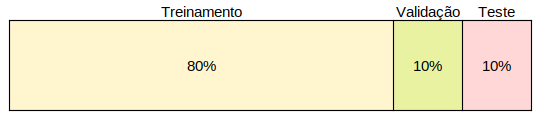

In [ ]:
# Define o tamanho do conjunto de treinamento como 80% dos dados disponíveis.
tamanho_treinamento = int(len(preco) * 0.8)

# Define o tamanho do conjunto de validação como 10% dos dados disponíveis.
# Os dados de validação são usados para avaliar o modelo ao final de cada época.
tamanho_valid = int(len(preco) * 0.1)

# Define o tamanho do conjunto de teste como o restante dos dados.
# Usados para avaliar o modelo depois de treinado
tamanho_teste = len(preco) - tamanho_treinamento - tamanho_valid

In [ ]:
# dados_treinamento: dados que serão utilizados para treinar o modelo
# vai do primeiro até o último dia dos dados de treinamento
dados_treinamento = np.array(preco[ : tamanho_treinamento])



**Dados de teste:** dados de teste inclui 15 dias anteriores, final do conjunto de validação

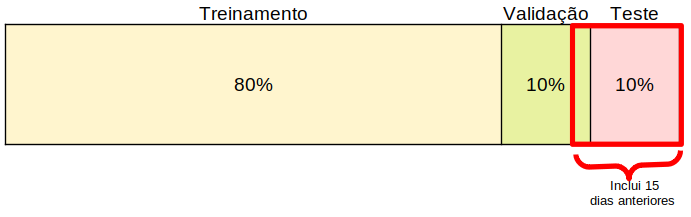


In [ ]:
# Extrai os dados de validação logo após o conjunto de treinamento.
dados_validacao =  np.array(preco[ tamanho_treinamento : tamanho_treinamento + tamanho_valid ])

# para cada nova projeção, este é o intervalo anterior que eu vou olhar
dias_anteriores = 15  # dias necessários para criar a entrada correta para a primeira previsão.

# dados de teste
# começo a selecionar os dados de 15 dias (variável dias_anteriores) antes do inicio do conjunto de teste
dados_teste = np.array(preco[tamanho_treinamento + tamanho_valid - dias_anteriores:])

dados_treinamento.shape

(4116, 1)

## **3 - Gráfico dos dados divididos entre  treinamento, validação e teste**

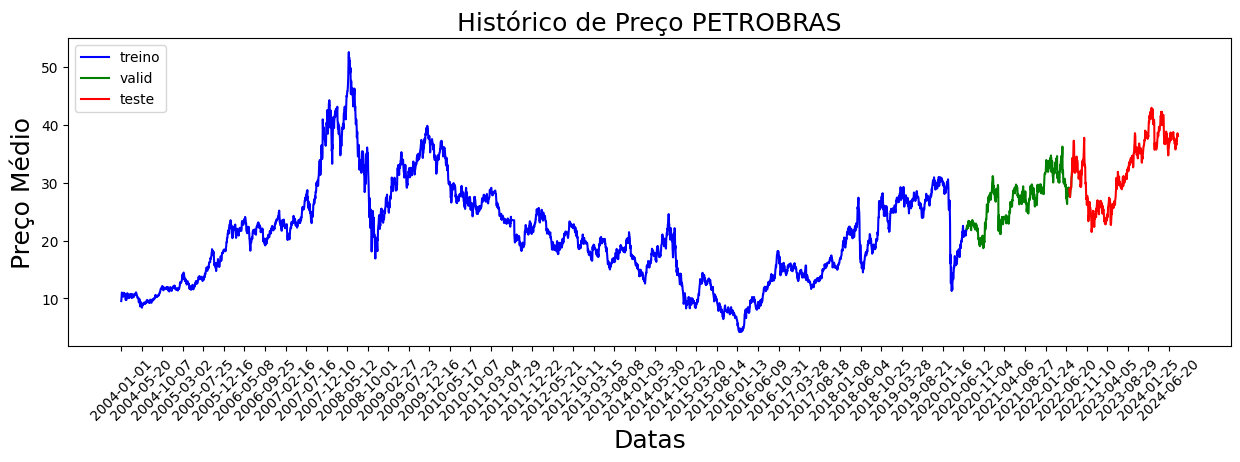

In [ ]:
# gráfico que mostra todos os dados, divididos entre  treinamento, validação e teste
import matplotlib.pyplot as plt

plt.figure(figsize = (15,4)) # tamanho da figura
plt.plot(data['Close'].loc[0:tamanho_treinamento], color = 'blue', label = 'treino')
plt.plot(data['Close'].loc[tamanho_treinamento:tamanho_treinamento + tamanho_valid], color = 'green', label = 'valid')
plt.plot(data['Close'].loc[tamanho_treinamento + tamanho_valid - dias_anteriores:], color = 'red', label = 'teste')
plt.xticks(range(0,data.shape[0],100), data['Date'].loc[::100], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Médio', fontsize=18)
plt.title("Histórico de Preço PETROBRAS", fontsize=18)
plt.legend()
plt.show()

## **4 - Preparação dos Dados (pre-processamento)**

In [ ]:
# Configura o normalizador para que os dados estejam dentro de um intervalo específico (0 e 1, nesse caso)
# Isso ajuda a melhorar o desempenho do modelo
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

# fit() ajusta o transformador para calcular o valor de minimo e máximo nos dados (quando usado depois do MinMaxScaller)
# transform() :calcula estatísticas com o valor de minimo e máximo nos dados (quando usado depois do MinMaxScaller)
#             : normaliza novos dados (por exemplo, dados de teste) com a mesma escala (quando usado depois do MinMaxScaller)
# fit_transform(): ajusta o transformador e executa a transformação
#                :Não uso fit_transform nos dados de teste porque isso recalcularia as estatísticas com base nos dados de testes

# Só aplico nos dados de treinamento (Calcula o mínimo e máximo a partir dos dados fornecidos e normaliza os dados)

# reshape(-1, 1): Redimensiona o array para garantir que ele tenha a forma correta para o MinMaxScaler.
#    -1 significa que o número de linhas será determinado automaticamente com base no comprimento do array original.
#     1 indica que haverá uma coluna.
#     Transforma o array 1D em um array 2D com uma única coluna e a quantidade de linhas do array original.
#     Por exemplo, um array de forma (950,) será transformado em (950, 1).

treino_data_norm = scaler.fit_transform(np.array(dados_treinamento).reshape(-1,1))

#test_data_norm = scaler.transform(np.array(dados_entrada).reshape(-1,1))

teste_data_norm = scaler.transform(np.array(dados_teste).reshape(-1,1))

val_data_norm = scaler.transform(np.array(dados_validacao).reshape(-1,1))

treino_data_norm.shape


(4116, 1)

In [ ]:
#treino
X_train, y_train = [], []
for i in range(dias_anteriores, tamanho_treinamento):
    X_train.append(treino_data_norm[i-dias_anteriores:i]) # x armazena o preço das ações dos 15 dias anteriores
    y_train.append(treino_data_norm[i])                   # armazena o preço da ação naquele dia

#validação
X_val, y_val = [], []
for i in range(dias_anteriores, tamanho_valid):
    X_val.append(val_data_norm[i-dias_anteriores:i])    # x armazena o preço das ações dos 15 dias anteriores
    y_val.append(val_data_norm[i])                      # armazena o preço da ação naquele dia

#teste
X_test = []
for i in range(dias_anteriores, tamanho_teste + dias_anteriores):
    X_test.append(teste_data_norm[i-dias_anteriores:i]) # X_test armazena as sequências dos preços dos últimos 15 dias


#converter tudo pra matriz numpy
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)

X_val = np.array(X_val)
y_val = np.array(y_val)


X_train.shape


#print(X_val.shape)
#print(y_val.shape)

(4101, 15, 1)

## **5 - Construção do Modelo**

In [ ]:
model = models.Sequential()

# Adiciona uma camada LSTM com 100 unidades.
# "LSTM" é uma camada de redes neurais recorrentes especializada em capturar dependências temporais em dados sequenciais.
#A camada recebe sequências de 15 dias como entrada.
# return_sequences=False: Indica que a camada RNN irá retornar apenas a última saída da sequência de entradas,
# em vez de retornar a saída de cada passo da sequência

rnn_units = 100

model.add(layers.LSTM(rnn_units, return_sequences=False))

# Adiciona uma camada totalmente conectada (Dense) com uma unidade, que gera a previsão de preço para o próximo dia.
model.add(layers.Dense(1))

# Compila o modelo especificando o otimizador 'rmsprop' e a função de perda 'mean_squared_error'.
# A métrica 'mean_absolute_error' é usada para avaliar o desempenho do modelo
model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

# Exibe um resumo da arquitetura do modelo, mostrando as camadas e o número de parâmetros treináveis.
#model.summary()

## **6 - Treinamento da rede**

In [ ]:
# Treina o modelo por 20 épocas, utilizando um batch size de 32.
# Em cada iteração, processa lotes de 32 amostras, ajustando os pesos do modelo com base nos gradientes calculados a partir da perda

#Os dados de validação são usados para avaliar o modelo ao final de cada época.

model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0112 - mean_absolute_error: 0.0556 - val_loss: 7.4010e-04 - val_mean_absolute_error: 0.0209
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0011 - mean_absolute_error: 0.0238 - val_loss: 9.4658e-04 - val_mean_absolute_error: 0.0238
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.5717e-04 - mean_absolute_error: 0.0198 - val_loss: 5.9429e-04 - val_mean_absolute_error: 0.0183
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.1419e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0012 - val_mean_absolute_error: 0.0287
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 5.2327e-04 - mean_absolute_error: 0.0167 - val_loss: 4.4255e-04 - val_mean_absolute_error: 0.0157
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.4162e-04 - mean_absolute_error: 0.0150 - val_loss: 5.9180e-04 - val_mean_absolute_error: 0.0183
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - los

## **7 - Predição**

In [ ]:
# predição de valores pela rede
# Usa o modelo treinado para prever os preços no conjunto de teste.
predict = model.predict(X_test)

# Aplica a transformação inversa para obter os valores previstos na escala original para que possamos plotar no gráfico os resultados
predict = scaler.inverse_transform(predict)

# Obtêm os valores reais correspondentes às previsões para comparação.
real = dados_teste[dias_anteriores:]

#predict.shape

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


## **8 - Comparação dos valores reais com os previstos**

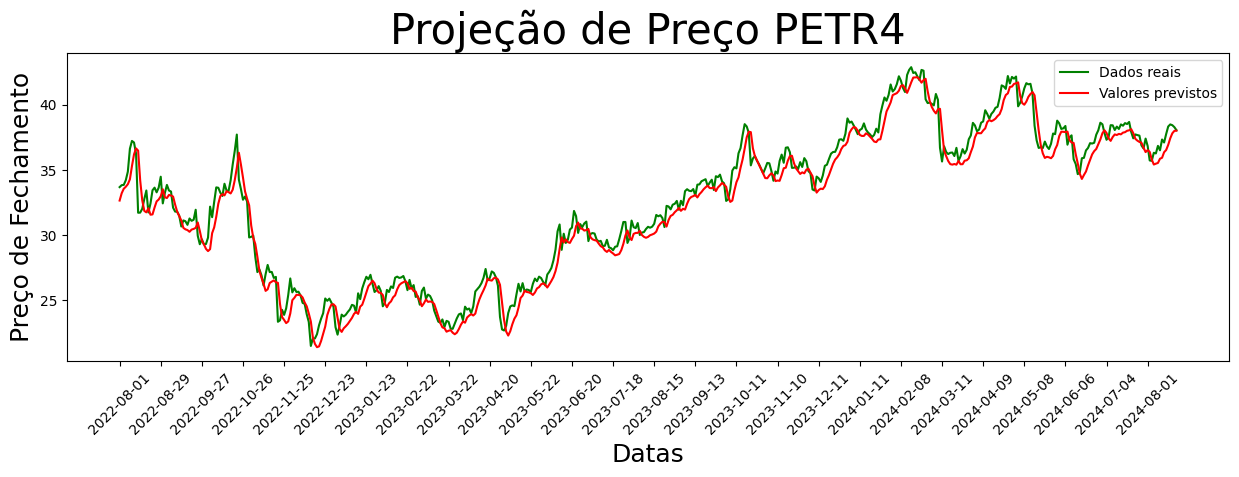

In [ ]:
# Plota um gráfico comparando os valores reais dos preços das ações com os valores previstos pelo modelo.
import matplotlib.pyplot as plt

plt.figure(figsize = (15,4))
plt.plot(real, color = 'green', label = 'Dados reais')
plt.plot(predict, color = 'red', label = 'Valores previstos')
plt.xticks(range(0, len(real), 20), data['Date'].iloc[- len(real)::20], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço de Fechamento', fontsize=18)
plt.title("Projeção de Preço PETR4", fontsize=30)
plt.legend()
plt.show()

In [ ]:
# Calcula o erro quadrático médio (MSE) entre os valores reais e previstos
# MSE é uma métrica que avalia a precisão das previsões do modelo.
# O MSE calcula a média dos quadrados das diferenças entre os valores previstos e os valores reais
# e pode retornar qualquer valor positivo, dependendo da escala dos dados.

from sklearn import metrics
metrics.mean_squared_error(real, predict)

1.0574347516291687